In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

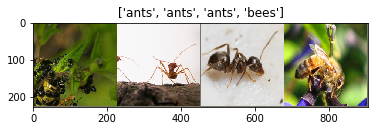

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  #update를 기다림


# 학습 데이터의 배치를 얻음
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만들어냄
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 epoch은 학습 단계와 검증 단계를 거침
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # param gradient를 0으로 설정
                optimizer.zero_grad()

                # foward
                # train phase에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # train phase인 경우 backprop, optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델 deep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 weight를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 각 출력 샘플의 크기는 2
# 또는, nn.Linear(num_ftrs, len (class_names))로 generalize
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimize가 잘 되었는지 확인
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 epoch마다 0.1씩 lr 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5960 Acc: 0.6598
val Loss: 0.2069 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4832 Acc: 0.8238
val Loss: 0.4045 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.7341 Acc: 0.7787
val Loss: 0.3405 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4445 Acc: 0.8238
val Loss: 0.7291 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.4463 Acc: 0.8197
val Loss: 0.3453 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4851 Acc: 0.8033
val Loss: 0.3764 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.3701 Acc: 0.8443
val Loss: 0.2430 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3545 Acc: 0.8525
val Loss: 0.2691 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3670 Acc: 0.8484
val Loss: 0.2494 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3110 Acc: 0.8770
val Loss: 0.2704 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3862 Acc: 0.8279
val Loss: 0.2526 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2445 Acc: 0.9016
val Loss: 0.2312 Acc: 0.9412

Ep

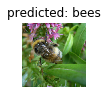

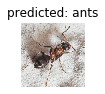

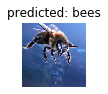

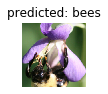

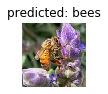

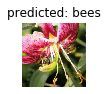

In [8]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 module의 param은 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 마지막 layer의 param만 optimize되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 epoch마다 0.1씩 lr 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6219 Acc: 0.6598
val Loss: 0.2126 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4968 Acc: 0.8033
val Loss: 0.6978 Acc: 0.7386

Epoch 2/24
----------
train Loss: 0.4983 Acc: 0.7787
val Loss: 0.2257 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4159 Acc: 0.7992
val Loss: 0.1433 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.5809 Acc: 0.7377
val Loss: 0.2826 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4401 Acc: 0.7992
val Loss: 0.3082 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4745 Acc: 0.8238
val Loss: 0.1633 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4063 Acc: 0.8115
val Loss: 0.1737 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2742 Acc: 0.8730
val Loss: 0.1731 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3372 Acc: 0.8484
val Loss: 0.1859 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3019 Acc: 0.8770
val Loss: 0.1747 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4174 Acc: 0.8115
val Loss: 0.1868 Acc: 0.9412

Ep

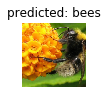

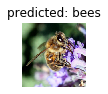

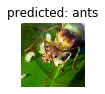

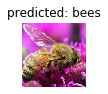

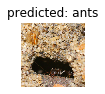

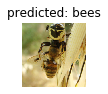

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()